In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [189]:
train = pd.read_csv("dengue_features_train.csv")
labels = pd.read_csv("dengue_labels_train.csv")
test = pd.read_csv("dengue_features_test.csv")

In [190]:
#submission file contains city,year,weekofyear, lets store them for future submission
test_city = test.city
test_year = test.year
test_week = test.weekofyear

In [191]:
#append test with train
final = train.append(test,ignore_index=True)

In [192]:
#Dropping week_start_date column as it is similar to the year column
final.drop('week_start_date',axis = 1,inplace =True)

In [193]:
#One hot encoding the city column
dummies = pd.get_dummies(final['city'],drop_first=True)
final = pd.concat([final,dummies],axis = 1)
final.drop('city',axis =1,inplace =True)

In [194]:
#Checking the percentage of nullvalues in the dataset
count=0
for i in final.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('It is',round((count/len(final.index))*100), 'percent of the entire dataset.')

Total number of rows with missing values is  320
It is 17 percent of the entire dataset.


In [195]:
#Filling null values using KNNImputer
from missingpy import KNNImputer
knn = KNNImputer()
final_knn = knn.fit_transform(final)
final = pd.DataFrame(final_knn,columns=final.columns)

In [196]:
#Null values are imputed
count=0
for i in final.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('It is',round((count/len(final.index))*100), 'percent of the entire dataset.')

Total number of rows with missing values is  0
It is 0 percent of the entire dataset.


In [197]:
#Storing the skewed columns in the list
list=[]
for i in final.columns:
    if final[i].skew()>1:
        list.append(i)

In [198]:
list

['precipitation_amt_mm',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_tdtr_k',
 'station_precip_mm']

In [199]:
#Transforming cube root function to reduce the skew
final['reanalysis_precip_amt_kg_per_m2'] = final['reanalysis_precip_amt_kg_per_m2'].map(lambda i: np.cbrt(i) if i > 0 else 0)
final['station_precip_mm'] = final['station_precip_mm'].map(lambda i: np.cbrt(i) if i > 0 else 0)
final['precipitation_amt_mm'] = final['precipitation_amt_mm'].map(lambda i: np.cbrt(i) if i > 0 else 0)
final['reanalysis_sat_precip_amt_mm'] = final['reanalysis_sat_precip_amt_mm'].map(lambda i: np.cbrt(i) if i > 0 else 0)
final['reanalysis_tdtr_k'] = final['reanalysis_tdtr_k'].map(lambda i: np.cbrt(i) if i > 0 else 0)

In [200]:
#By using pandas_profiling highly correlated variables are dropped
import pandas_profiling
profile = final.profile_report()
rejected = profile.get_rejected_variables(threshold=0.8)
final.drop(rejected,axis = 1,inplace = True)

In [201]:
# Splitting train and test
X = final.iloc[0:train.shape[0]]
test = final.iloc[train.shape[0]:]

y = labels['total_cases']
y = np.ravel(y)

from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval = train_test_split(X,y,test_size = 0.3,random_state = 1)

In [202]:
#Pandom Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=800)

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#Applying Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300)
rf.fit(xtrain,ytrain)
ypred = rf.predict(xtrain)
rf_ypred = rf.predict(xval)
print('TRAIN')
print('MAE: ',np.sqrt(mean_absolute_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('MAE: ',np.sqrt(mean_absolute_error(yval,rf_ypred)))
print('R2 value: ',r2_score(yval,rf_ypred)*100)


TRAIN
MAE:  2.309635489467983
R2 value:  93.6473767843573
TEST
MAE:  3.5137140062144474
R2 value:  57.91006014599886


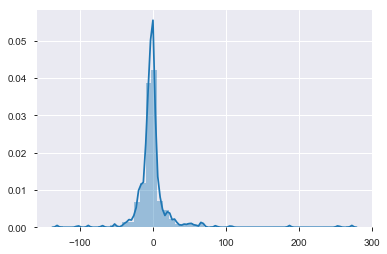

In [203]:
residuals = yval-rf_ypred
sns.distplot(residuals)

In [204]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=300,learning_rate=0.1)

gb.fit(xtrain,ytrain)
ypred = gb.predict(xtrain)
gb_ypred = gb.predict(xval)

print('TRAIN')
print('MAE: ',np.sqrt(mean_absolute_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('MAE: ',np.sqrt(mean_absolute_error(yval,gb_ypred)))
print('R2 value: ',r2_score(yval,gb_ypred)*100)

TRAIN
MAE:  2.2723210468751622
R2 value:  97.09059996369976
TEST
MAE:  3.6413829569170013
R2 value:  67.49010679305883


In [205]:
#XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(xtrain,ytrain)
ypred = xgb.predict(xtrain)

xgb_ypred = xgb.predict(xval)
print('TRAIN')
print('MAE: ',np.sqrt(mean_absolute_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('MAE: ',np.sqrt(mean_absolute_error(yval,xgb_ypred)))
print('R2 value: ',r2_score(yval,xgb_ypred)*100)

[19:19:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAIN
MAE:  3.072056181871506
R2 value:  86.02452730704046
TEST
MAE:  3.534842095805806
R2 value:  70.88998485071752


In [206]:
xgb.fit(X,y)

[19:19:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [207]:
predict = xgb.predict(test).astype(int)
sub = pd.DataFrame({'city':test_city,'year':test_year,'weekofyear':test_week,'total_cases':predict})
sub.to_csv('Submission.csv',index = False)

